<a href="https://colab.research.google.com/github/HomeschoolHarry/forecast_testing_Darts/blob/main/XGBoost_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### XGBoost Forecasting Model w/ Tito Vodka

Imports

In [1]:
from seaborn.palettes import SEABORN_PALETTES
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

API Grab

In [3]:
import requests

# Grab Tito's 750mL using item Code and All-Other A/O category sales
# use "where funtion to fix 2012 through Dec 2022"
url = f"https://data.iowa.gov/resource/m3tr-qhgy.json?$select=date_trunc_ym(date) as date,itemno='38176' as tito_750,sum(sale_dollars) as sales,sum(sale_liters) as volume&$group=date,tito_750&$where=date between '2012-01-01T00:00:00' and '2022-12-31T00:00:00'"
response = requests.get(url)
response.raise_for_status()

# To save as Pandas DataFrame
titos = response.json()
titos = pd.DataFrame(titos)

#convert types
convert_dict = {'date': object,
                'sales': float,
                'volume': float,
                }
titos = titos.astype(convert_dict)

# use numpy to convert year and month to datetime
titos['date'] = pd.to_datetime(titos['date'])

# grab 750 ml using True value
tito_750_only = titos[titos['tito_750'] == True]

#drop the boolean column
tito_750_only = tito_750_only.drop('tito_750', axis=1)

# Volume DataFrames
df_tito_volume = tito_750_only[['date', 'volume']]

# convert to standard 9L cases
def conv_nine(row):
  return (row['volume'] / 9).round(decimals=0)

df_tito_volume['volume (9L)'] = conv_nine(df_tito_volume)

# drop liter volume
df_tito_volume = df_tito_volume.drop(columns='volume')

Plotting Dataset

In [4]:
df_tito_volume

,date,volume (9L)
1,2012-01-01,58.0
3,2012-02-01,117.0
5,2012-03-01,93.0
7,2012-04-01,108.0
9,2012-05-01,195.0
...,...,...
255,2022-08-01,2221.0
257,2022-09-01,3371.0
259,2022-10-01,2883.0
261,2022-11-01,2479.0


Text(0.5, 1.0, 'Tito 9L Volume')

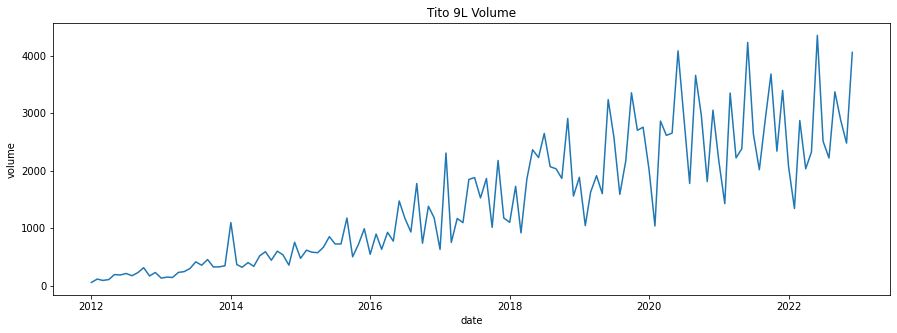

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df_tito_volume['date'], df_tito_volume['volume (9L)'])
plt.xlabel("date")
plt.ylabel("volume")
plt.title("Tito 9L Volume")

In [18]:
#set indexes to date and create train model
xg_train = df_tito_volume[0:121]
xg_train = xg_train.set_index('date')

xg_val = df_tito_volume[120:132]
xg_val = xg_val.set_index('date')

In [15]:
xg_train
xg_val

,volume (9L)
date,
2022-01-01,2076.0
2022-02-01,1343.0
2022-03-01,2872.0
2022-04-01,2034.0
2022-05-01,2324.0
2022-06-01,4352.0
2022-07-01,2511.0
2022-08-01,2221.0
2022-09-01,3371.0


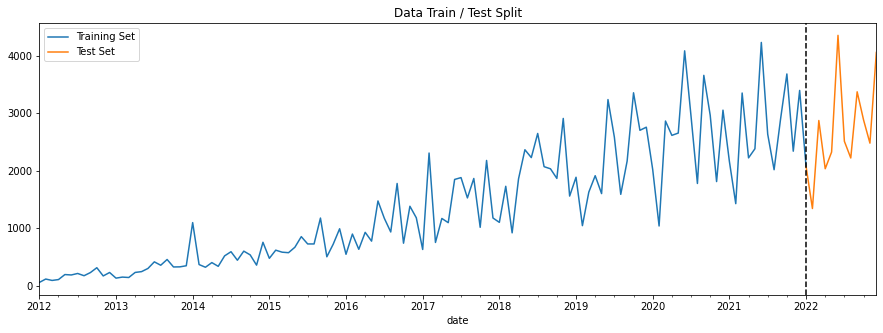

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
xg_train.plot(ax=ax, label='Training Set', title='Data Train / Test Split')
xg_val.plot(ax=ax, label='Test Set')
ax.axvline('2022-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
## Create Features
def create_features(df):
  """
  Create time series features based on time series index
  """
  df = df.copy()
  df['year'] = df.index.year
  df['month'] = df.index.month
  
  return df 

In [12]:
features = create_features(xg_train)
#features

,volume (9L),year,month
date,,,
2012-01-01,58.0,2012,1
2012-02-01,117.0,2012,2
2012-03-01,93.0,2012,3
2012-04-01,108.0,2012,4
2012-05-01,195.0,2012,5
...,...,...,...
2022-08-01,2221.0,2022,8
2022-09-01,3371.0,2022,9
2022-10-01,2883.0,2022,10


Plot Monthly Descrete Boxplot

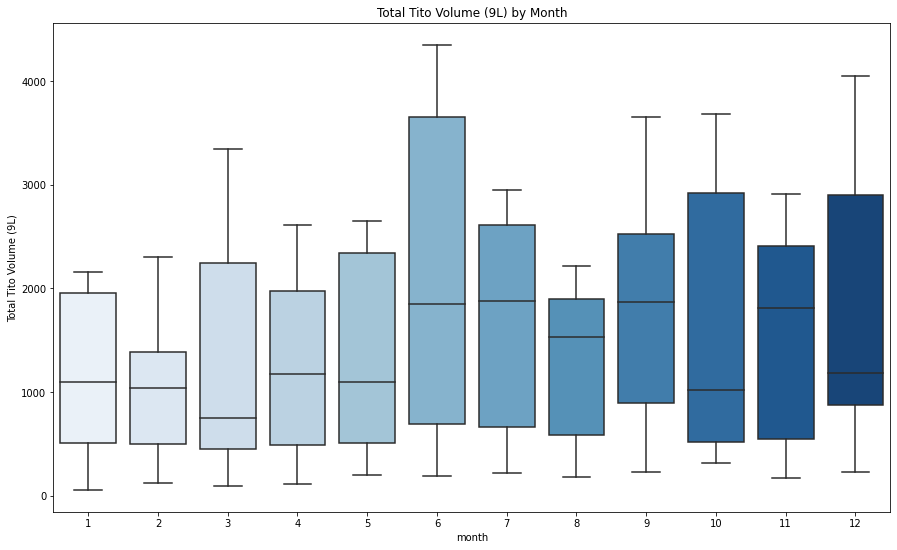

In [13]:
fig, ax = plt.subplots(figsize=(15,9))
sns.boxplot(data=features, x='month', y='volume (9L)', palette='Blues')
ax.set_title('Total Tito Volume (9L) by Month')
ax.set_ylabel('Total Tito Volume (9L)')
plt.show()

Create training set

In [20]:
trainxg = create_features(xg_train)
testxg = create_features(xg_val)

# Create Models
FEATURES = ['year','month']
TARGETS = ['volume (9L)'] 

X_train = trainxg[FEATURES]
Y_train = trainxg[TARGETS]

X_test = testxg[FEATURES]
Y_test = testxg[TARGETS]

In [21]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=True)


[0]	validation_0-rmse:1271.26072	validation_1-rmse:2125.25994
[1]	validation_0-rmse:957.11698	validation_1-rmse:1652.93447
[2]	validation_0-rmse:739.42491	validation_1-rmse:1278.30568
[3]	validation_0-rmse:593.64258	validation_1-rmse:1030.70551
[4]	validation_0-rmse:480.58837	validation_1-rmse:841.74713
[5]	validation_0-rmse:401.85871	validation_1-rmse:727.29117
[6]	validation_0-rmse:338.10054	validation_1-rmse:627.09064
[7]	validation_0-rmse:303.32930	validation_1-rmse:575.71228
[8]	validation_0-rmse:259.53975	validation_1-rmse:501.61677
[9]	validation_0-rmse:226.63853	validation_1-rmse:459.68791
[10]	validation_0-rmse:202.58473	validation_1-rmse:427.05930
[11]	validation_0-rmse:182.15094	validation_1-rmse:403.16284
[12]	validation_0-rmse:168.18694	validation_1-rmse:386.83114
[13]	validation_0-rmse:157.90520	validation_1-rmse:374.99688
[14]	validation_0-rmse:148.44653	validation_1-rmse:367.42700
[15]	validation_0-rmse:134.95215	validation_1-rmse:363.20394
[16]	validation_0-rmse:126.74

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
xg_forecast = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

In [35]:
X_test

,year,month
date,,
2022-01-01,2022,1
2022-02-01,2022,2
2022-03-01,2022,3
2022-04-01,2022,4
2022-05-01,2022,5
2022-06-01,2022,6
2022-07-01,2022,7
2022-08-01,2022,8
2022-09-01,2022,9


In [27]:
xg_forecast
testxg['predictions'] = reg.predict(X_test)
testxg

,volume (9L),year,month,predictions
date,,,,
2022-01-01,2076.0,2022,1,2090.869873
2022-02-01,1343.0,2022,2,1480.858765
2022-03-01,2872.0,2022,3,3228.837891
2022-04-01,2034.0,2022,4,2253.910645
2022-05-01,2324.0,2022,5,2386.104248
2022-06-01,4352.0,2022,6,4114.816406
2022-07-01,2511.0,2022,7,2634.610596
2022-08-01,2221.0,2022,8,2052.856445
2022-09-01,3371.0,2022,9,2924.537842


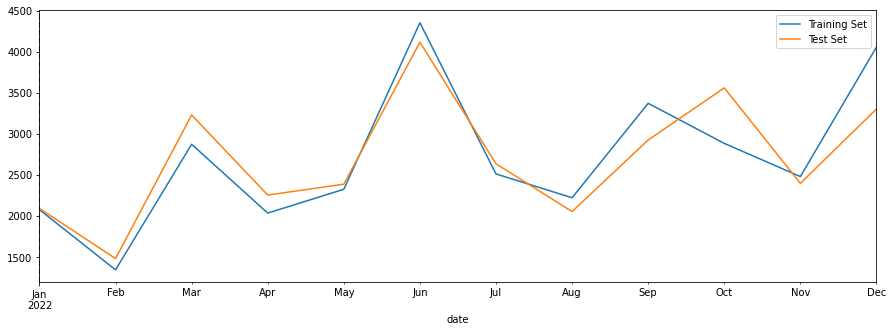

In [28]:
fig, ax = plt.subplots(figsize=(15,5))
xg_val.plot(ax=ax, label='Test Set')
testxg['predictions'].plot(ax=ax, label='forecast')
ax.axvline('2022-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Use Fitted Model to Predict 12 months for 2023

Create Prediction DataFrame and Train entire series

In [151]:
# Create prediction DataFrame
X_Predict_data = {
    'year' :[2023, 2023,2023, 2023,2023, 2023,2023, 2023,2023, 2023,2023, 2023],
    'month':[1,2,3,4,5,6,7,8,9,10,11,12],
    
}
X_Predict = pd.DataFrame(X_Predict_data)

Use the fitted model to forecast 2023

In [152]:
X_Predict['forecast'] = reg.predict(X_Predict)

In [158]:
type(X_Predict)
X_Predict.set_index('month')

,year,forecast
month,,
1,2023,2090.869873
2,2023,1480.858765
3,2023,3228.837891
4,2023,2253.910645
5,2023,2386.104248
6,2023,4114.816406
7,2023,2634.610596
8,2023,2052.856445
9,2023,2924.537842


Normalize for Weighted

In [170]:
# Create features for entire tito_series
df_tito_v = df_tito_volume
df_tito_v = df_tito_v.set_index('date')

series_feature = create_features(df_tito_v)
#features

In [171]:
series_feature.set_index('month')

,volume (9L),year
month,,
1,58.0,2012
2,117.0,2012
3,93.0,2012
4,108.0,2012
5,195.0,2012
...,...,...
8,2221.0,2022
9,3371.0,2022
10,2883.0,2022


In [172]:
# Weighted Values

#Sum all sales in month using Discrete Method

agg_sales = series_feature.groupby('month')['volume (9L)'].sum().to_frame()
agg_sales

,volume (9L)
month,
1,12192.0
2,11045.0
3,14163.0
4,14058.0
5,14647.0
6,23313.0
7,18322.0
8,13840.0
9,20226.0


In [173]:
# convert to weighted average
def weighted_ave(row):
  return (row['volume (9L)'] / row['volume (9L)'].sum())

In [174]:
agg_sales['weights'] = weighted_ave(agg_sales)
agg_sales['weights'].sum()

1.0

In [183]:
### Apply Weighted Average to forecast ###

#Sum X_Predict Forecast
X_Predict_total = X_Predict['forecast'].sum()

def apply_weight(row):
  return (row['weights'] * X_Predict_total)

agg_sales['weights'].sum()

agg_sales['weighted_forecast'] = apply_weight(agg_sales)

final_xgb_results = agg_sales.merge(X_Predict, left_on='month', right_on='month')


CONVERT FINAL TABLE FOR EXPORT

In [177]:
#add forecast and convert to CSV for Tableau or other visualization software


In [185]:
final_xgb_results.to_csv('xgb_final_results.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [150]:
agg_sales

,volume (9L),weights,forecast,weighted_forecast,final_forecast
month,,,,,
1,12192.0,0.061927,1480.858765,2007.975876,1480.858765
2,11045.0,0.056101,3228.837891,1819.069353,3228.837891
3,14163.0,0.071938,2253.910645,2332.592055,2253.910645
4,14058.0,0.071405,2386.104248,2315.298955,2386.104248
5,14647.0,0.074397,4114.816406,2412.305008,4114.816406
6,23313.0,0.118414,2634.610596,3839.562138,2634.610596
7,18322.0,0.093063,2052.856445,3017.563484,2052.856445
8,13840.0,0.070298,2924.537842,2279.395187,2924.537842
9,20226.0,0.102734,3558.832520,3331.145018,3558.832520
